In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import json
import glob
import numpy as np
from PIL import Image
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
#from scipy.misc import imsave
from imageio import imwrite
from sklearn.cluster import DBSCAN
from shapely.geometry import box
Image.MAX_IMAGE_PIXELS = None

In [2]:
#To do: move these functions to .py files

def convert_coords(image, label, x, y): 
    
    ''' 
    convert from geographic coordinates to image-scaled coordinates, relative to bottom left of image
    '''

    # get coordinates defining extent of input image and labels
    bbox = image.bounds #features.bounds(label)    #bounding box of image - this is different to bounding box of labels
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3] #label['bbox'][0], label['bbox'][1], label['bbox'][2], label['bbox'][3]
    
    # get distance of point x,y from image origin
    x_relative = x - x_min
    y_relative = y - y_min
        
    # get scaling factors
    width = x_max - x_min
    height = y_max - y_min
    #(width_pix, height_pix) = image.size
    (height_pix, width_pix) = image.shape

    
    x_pix = x_relative/width * width_pix
    y_pix = y_relative/height * height_pix
    
    return x_pix, y_pix

In [3]:
def save_files(image, label, info, output_dir, input_name):
    
    '''
    for each cluster of bounding boxes, save a 512x512 image chip as .png
    along with bounding box labels in YOLO format as .json
    '''
    
    # initialise a figure to visualise output tiles
    fig = plt.figure(figsize=(20, 100))
    n_tiles = len(info.keys())
    
    for i,k in enumerate(info.keys()):
                             
        # get centre of each bounding box cluster
        x, y = info[k]['centre'][0], info[k]['centre'][1] # in pixels, with origin in lower left
        
        # define coordinates for cropping
        # set limits since tile boundaries cannot exceed image boundaries
        #width, height = image.getbbox()[2], image.getbbox()[3]      #2,3 are right and lower bounds
        width, height = image.bounds[2], image.bounds[1]
        left, top, right, bottom = x-256, (height-y)-256, x+256, (height-y)+256 # in accordance with PIL library: in pix, origin top left
               
        left_lim, top_lim = max(0,int(left)), max(0,int(top))
        right_lim, bottom_lim = min(width, int(right)), min(height, int(bottom))
               
        # crop and save image tiles
        image_name = '{}/{}_{}.png'.format(output_dir, input_name, k)
        #image_str = file_path + '/' + image_name
        # it goes left-top-right-bottom where bottom=top+height (i.e. the origin is in the top left corner)
        #image_tile = image.crop([left_lim, top_lim, right_lim, bottom_lim])
        
        crop_bbox = [{'type': 'Polygon', 'coordinates': [[[left_lim, bottom_lim], [left_lim, top_lim], [right_lim, top_lim], [right_lim, bottom_lim], [left_lim, bottom_lim]]]}]
        print(crop_bbox)
        print(image.transform)
        image_tile, image_tile_transform = mask(image, crop_bbox, crop=True)
        #imwrite(image_name, image_tile)

        ax = fig.add_subplot(n_tiles, 4, i+1)
        ax.imshow(image_tile)
                
        # save label file
        #file = open(image_name.replace('.png', '.txt'), 'a')
        
        for j, box in enumerate(info[k]['object_boxes']):
            # get coordinates of lower left (x1) and upper right (x3) corner of bounding box
            [[x1, y1], [x3, y3]] = box # in px, origin in lower left
            
            # define bounding box coordinates relative to boundaries of current image tile
            x1_rel, x3_rel = x1-left_lim, x3-left_lim
            y1_rel, y3_rel = (height-y1)-top_lim, (height-y3)-top_lim
            
            # get some scaling factors to convert from image to tile coordinates
            tile_width = right_lim - left_lim
            tile_height = top_lim - bottom_lim

            # define bounding box centre & width
            box_centre_x = (x1_rel+x3_rel)//2
            box_centre_y = (y1_rel+y3_rel)//2
            box_width = x3-x1
            box_height = y1-y3
            
            # add bounding boxes to tile subplot
            rect = patches.Rectangle((x1_rel, y1_rel), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            title = str(i+1)
            ax.set_title(title)

            # write label to .txt file
            ## 0 means first object i.e. whale
            ## (add a line here for multiple categoties - if info[k]['name'] = 'ship': lab = ...)
            
            #
            #lab = '0 {} {} {} {}\n'.format(abs(box_centre_x/tile_width), abs(box_centre_y/tile_height), abs(box_width/tile_width), abs(box_height/tile_height))
            #file.write(lab)
        #file.close()
    plt.show()

In [103]:
#Data paths:

liebre1_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif"
liebre1_rgb_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif"
liebre1_nostretch_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_nostretch.tif"
liebre1_points_shp_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre_points_2015_image.shp"
liebre1_boxes_shp_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.shp"

In [84]:
#checking image path exists
import os.path
from os import path 
print(path.exists(liebre1_image_path))
print(path.isfile(liebre1_image_path))
print(path.getsize(liebre1_image_path))
print(path.isabs(liebre1_image_path))
print(path.abspath(liebre1_image_path))

True
True
10337293250
True
/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif


In [6]:
#Export shapefiles to a geojson with bounding box
import geopandas
#liebre_bbox = (778562.590800, 3063219.728100, 796312.956300, 3072412.944500)
image_bbox = (777470.0,3057298.0,797147.5,3073682.0)
liebre_box_shpfile = geopandas.read_file(liebre1_boxes_shp_path, bbox=image_bbox)
#liebre_box_shpfile.to_file('/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.geojson', driver='GeoJSON')

In [7]:
liebre1_box_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.geojson"

In [8]:
#look at geojson point file
boxes = geopandas.read_file(liebre1_box_path)
boxes.head()


,OBJECTID,Name,BUFF_DIST,ORIG_FID,ORIG_FID_1,Shape_Leng,Shape_Area,geometry
0,1,None,10.0,0,1,80.0,400.0,"POLYGON ((778808.654 3071294.011, 778808.654 3..."
1,2,None,10.0,1,2,80.0,400.0,"POLYGON ((778562.591 3070990.798, 778562.591 3..."
2,3,None,10.0,2,3,80.0,400.0,"POLYGON ((778990.224 3070470.196, 778990.224 3..."
3,4,None,10.0,3,4,80.0,400.0,"POLYGON ((778664.985 3070251.617, 778664.985 3..."
4,5,None,10.0,4,5,80.0,400.0,"POLYGON ((778688.401 3070245.664, 778688.401 3..."


In [9]:
boxes.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
#checking 
from rasterio import features
from rasterio.plot import show
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    print(features.bounds(label))
    #print(label)
    first = label['features'][0]
    print(first)
    print(first['geometry']['coordinates'][0][0][0])

(778562.5908000004, 3063219.7281, 796312.9562999997, 3072412.9444999993)
{'type': 'Feature', 'properties': {'OBJECTID': 1, 'Name': None, 'BUFF_DIST': 10.0, 'ORIG_FID': 0, 'ORIG_FID_1': 1, 'Shape_Leng': 80.0, 'Shape_Area': 400.0}, 'geometry': {'type': 'Polygon', 'coordinates': [[[778808.6538000004, 3071294.011499999], [778808.6538000004, 3071314.011499999], [778828.6538000004, 3071314.011499999], [778828.6538000004, 3071294.011499999], [778808.6538000004, 3071294.011499999]]]}}
778808.6538000004


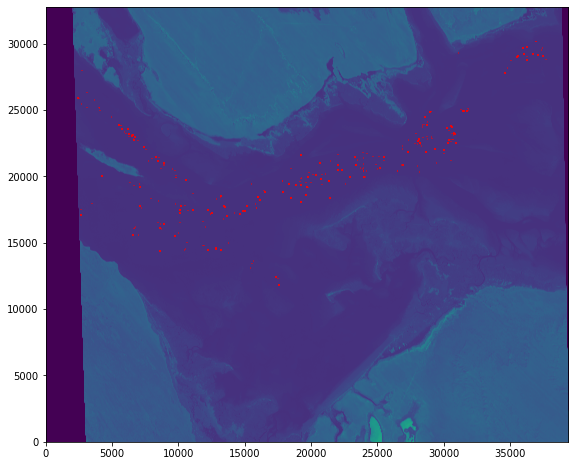

In [10]:
# visualise input image file + bounding boxes from label file
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    #image = Image.open(liebre1_image_path)
    image = rasterio.open(liebre1_image_path)
    
    # create figure
    fig1 = plt.figure(figsize=(16, 8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(np.flipud(image.read(1)), origin='lower') #  flip because imshow defines upper left as origin

    # plot bounding boxes
    for object in label['features']:
        
        # get origin and dimensions of each bounding box
        bottom_left_unconv = object['geometry']['coordinates'][0][0]
        top_right_unconv = object['geometry']['coordinates'][0][2]

        bottom_left = convert_coords(image, label, bottom_left_unconv[0], bottom_left_unconv[1])
        #print(bottom_left)
        top_right = convert_coords(image, label, top_right_unconv[0], top_right_unconv[1])

        width = top_right[0] - bottom_left[0]
        height = top_right[1] - bottom_left[1]

        # add bounding box to figure
        rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        
    plt.show

In [19]:
def read_coords(label):
    coords, centres = [], []
    
    for object in label['features']:
        # get coordinates of lower left & upper right corners of each bounding box
        [[x1, y1], [x3, y3]] = object['geometry']['coordinates'][0][0], object['geometry']['coordinates'][0][2]
        coords.append([[x1, y1], [x3, y3]])

        # store centre coordinate of each bounding box for clustering
        centres.append([(x1+x3)//2, (y1+y3)//2])
    return np.array(coords), centres

In [20]:
file_save_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/cropped_images"

In [21]:
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    #label['liebre1_image_path'] = image_file    #What is this for?
    #image = Image.open(liebre1_image_path)
    image = rasterio.open(liebre1_image_path)#.read()
    #image = reshape_as_image(image1)
    print(type(image))

    coords, centres = read_coords(label)
    
    # convert bounding box coordinates from geographic to image-scaled
    centres_converted = np.array([convert_coords(image, label, point[0], point[1]) for point in centres])
    
    coords_converted = np.array([[convert_coords(image, label, point[0][0], point[0][1]), 
                                  convert_coords(image, label, point[1][0], point[1][1])] 
                            for point in coords
                       ])    
    
    ## DB-Scan algorithm for clustering ##
    
    eps = 250 # threshold distance between two points to be in the same 'neighbourhood'
    dbscan = DBSCAN(min_samples=1, eps=eps)
    y = dbscan.fit_predict(centres_converted)

    # storing coordinates of clusters, relative to boundaries of image (not tile)
    info = {}
    for i in range(y.max()+1):
        
        # calculate the max and min coords of all the bounding boxes in the cluster
        box_centres = centres_converted[np.where(y==i)[0]]
        min_x, max_x = box_centres[:, 0].min(), box_centres[:, 0].max()
        min_y, max_y = box_centres[:, 1].min(), box_centres[:, 1].max()
        
        # assign each cluster of objects as an item
        item = {}
        item['centre'] = [(min_x+max_x)//2, (min_y+max_y)//2]
        item['object_boxes'] = coords_converted[np.where(y==i)[0]].tolist()
        item['name'] = "whale"
        info[i] = item
        
        # add a line here to generalize to multiple categories:
        # if label['features']['NumShip'] == ... : 

    save_files(image, label, info, file_save_path, 'liebre1')

<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'bounds'

In [11]:
#from rasterio.transform import Affine
#print(image.transform)
#print(image.transform*(0,0))
#transform = Affine(0.5,0.0, 0,
                    #0.0 , -0.5, 0)
#print(transform*(0,0))

In [9]:
#with rasterio.open(
    #liebre1_new_image_path, 
    #'w',
    #driver = 'GTiff',
    #height = image.shape[0],
    #width = image.shape[1],
    #counts = 4,
    #transform = transform,
#) as dst:
   # dst.write(image)
    

In [11]:
#Try loading in as an array and converting to PIL
image = rasterio.open(liebre1_image_path).read()
image_array = reshape_as_image(image)

In [12]:
image_array.shape

(32768, 39355, 4)

In [60]:
import cv2 as cv
#imageRGB = cv.cvtColor(image_array, cv.COLOR_BGR2RGB)
#imageRGB.shape

In [89]:
#PIL_image = Image.fromarray(np.uint8(image_array)).convert('RGB')
#PIL_image = Image.fromarray(np.uint8(image_array), 'RGBA')
PIL_image = Image.fromarray(np.uint8(imageRGB))

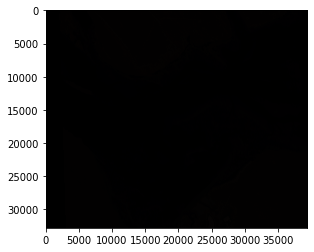

In [88]:
plt.imshow(PIL_image)

In [15]:
PIL_image.size

(39355, 32768)

In [102]:
#Try loading with open cv and converting to PIL
image  = cv.imread('/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif', cv.IMREAD_UNCHANGED)
print(image)

None


In [63]:
image.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [47]:
#from skimage import io
import tifffile as tiff
a = tiff.imread(liebre1_image_path)

In [114]:
print(a.dtype)
print(a)

uint16
[[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 ...

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [550 554 811 893]
  [547 551 808 890]
  [513 517 774 856]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [526 530 787 869]
  [476 480 737 819]
  [470 474 731 813]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [492 496 753 835]
  [437 441 698 780]
  [478 482 739 821]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


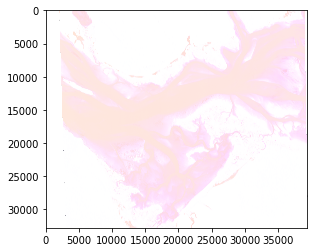

In [95]:
#print(a)
plt.imshow(a, cmap='gray', vmin=0, vmax=65535)

In [92]:
PIL_image = Image.fromarray(np.uint8(a))

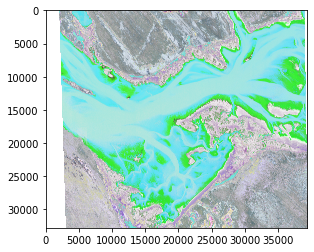

In [93]:
plt.imshow(PIL_image)

## Try rgb image

In [106]:
Image.open(r'/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif')

UnidentifiedImageError: cannot identify image file '/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif'

In [107]:
#Try loading with open cv and converting to PIL
image  = cv.imread('/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif', cv.IMREAD_UNCHANGED)
print(image)

None


In [109]:
rgb = tiff.imread('/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif')

In [111]:
print(rgb.dtype)
print(rgb.shape)

uint8
(32768, 39355, 3)


In [112]:
PIL_rgb = Image.fromarray(rgb)

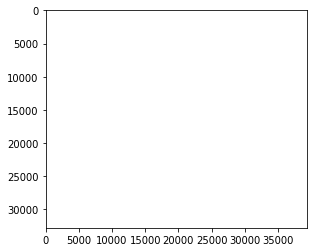

In [113]:
plt.imshow(PIL_rgb)